In [1]:
#from pathlib import Path

import glob
import altair as alt
import pandas as pd
import numpy as np

alt.__version__

'2.1.0'

## Curated telomeric coordinates, multimapped reads found within BEDfile limits

### 10X & Truseq datasets

In [2]:
chr_array = ['chr'+str(x) for x in range(1,23)]
chr_array.append('chrX')
chr_array.append('chrY')
chr_array.append('chrM')

chr_cat = pd.Series(chr_array, dtype="category")

In [3]:
colo829bl_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-10X-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829t_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-10X-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829bl = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829t = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-hg38.hist.csv", dtype={"mmap_count": np.int})

colo829bl_10x['technology'] = '10X'
colo829bl_10x['sample'] = 'colo829bl_10x'
colo829t_10x['technology'] = '10X'
colo829t_10x['sample'] = 'colo829t_10x'

colo829t['technology'] = 'Truseq'
colo829t['sample'] = 'colo829t'
colo829bl['technology'] = 'Truseq'
colo829bl['sample'] = 'colo829bl'

In [4]:
#colo829bl['chromosome'] = colo829bl['chromosome'].astype('category')
#colo829bl['chromosome_cat'] = colo829bl['chromosome'].cat.codes

#avail_chroms = chr_cat[chr_cat.isin(colo829bl['chromosome'])]
#new_chrom_cats_ordered = avail_chroms.astype('category')
#colo829bl['chromosome_cat_ordered'] = new_chrom_cats_ordered.cat.codes

#colo829bl['chromosome'].cat.reorder_categories(new_chrom_cats_ordered, inplace=True)
#colo829bl['chromosome']

In [5]:
#s = colo829bl['chromosome'].replace(chr_dict)
#s

In [6]:
colo829bl["chromosome"] = pd.Categorical(colo829bl["chromosome"], chr_array)

In [7]:
colo829bl.sort_values("chromosome")

,chromosome,mmap_count,technology,sample
1,chr1,8515,Truseq,colo829bl
10,chr2,477,Truseq,colo829bl
7,chr3,1897,Truseq,colo829bl
12,chr4,365,Truseq,colo829bl
0,chr5,70691,Truseq,colo829bl
11,chr7,471,Truseq,colo829bl
14,chr9,311,Truseq,colo829bl
4,chr10,2637,Truseq,colo829bl
17,chr11,58,Truseq,colo829bl
2,chr12,5772,Truseq,colo829bl


In [8]:
datasets = [colo829bl_10x, colo829t_10x, colo829bl, colo829t]
datasets_excluded_chroms = []

for ds in datasets:
    ds = ds[ds['chromosome'] != 'chr5']
    ds = ds[ds['chromosome'] != 'chr1']
    ds = ds[ds['chromosome'] != 'chrX']
    ds = ds[ds['chromosome'] != 'chr22']
    ds = ds[ds['chromosome'] != 'chrY']
    ds = ds[ds['chromosome'] != 'chr12']
    ds = ds[ds['chromosome'] != 'chr18']
    ds = ds[ds['chromosome'] != 'chr10']

    datasets_excluded_chroms.append(ds)

In [9]:
#dataset_curated = pd.concat(datasets_excluded_chroms, ignore_index=True)
dataset_curated = pd.concat(datasets, ignore_index=True)
dataset_curated.reset_index()

dataset_curated["log"] = dataset_curated["mmap_count"].apply(np.log)

dataset_curated["chromosome"] = pd.Categorical(dataset_curated["chromosome"], chr_array)
dataset_curated = dataset_curated.sort_values("chromosome")

pat = r"chr(.*)"
repl = lambda m: m.group(1)

dataset_curated['chromosome'] = dataset_curated['chromosome'].str.replace(pat, repl)

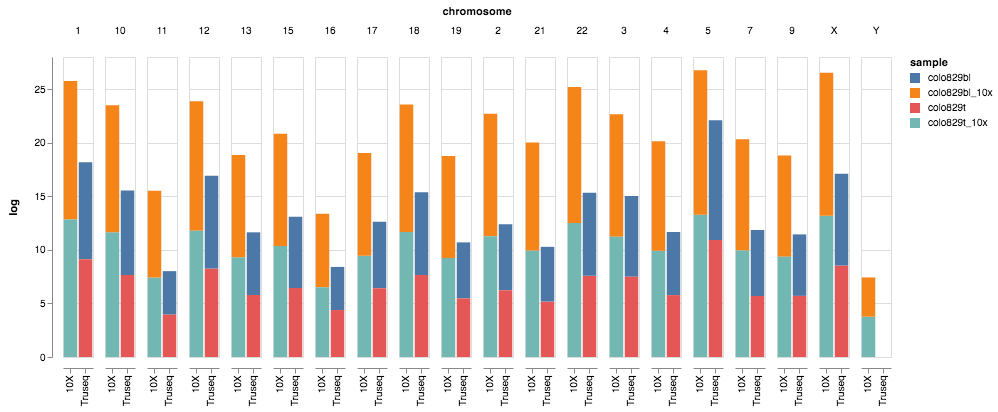

In [10]:

sample_chart = alt.Chart(dataset_curated).mark_bar().encode(
        alt.X('sample:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('mmap_count:Q', axis=alt.Axis(title='Mapped reads')),
        color = alt.Color('sample:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)

tech_chart = alt.Chart(dataset_curated).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('mmap_count:Q', axis=alt.Axis(title='Mapped reads')),
        color = alt.Color('technology:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)

logplot = alt.Chart(dataset_curated).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'log:Q',
        color = alt.Color('sample:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        #column = 'chromosome:N'
        column = alt.Column('chromosome:N', sort='ascending')
)


#sample_chart
#| tech_chart | logplot
#sample_chart | tech_chart | logplot
logplot

## Absolute mapped reads for the whole datasets (samtools idxstats)

https://standage.github.io/an-idiots-guide-to-loading-reads-from-a-bam-file.html

### 10X

In [5]:
colo829bl_10x_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829BL-10X-baseline-idxstats-hg38.hist.csv")
colo829t_10x_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829T-10X-baseline-idxstats-hg38.hist.csv")

colo829bl_10x_baseline['technology'] = '10X'
colo829bl_10x_baseline['sample'] = 'colo829bl_10x'
colo829t_10x_baseline['technology'] = '10X'
colo829t_10x_baseline['sample'] = 'colo829t_10x'

### Truseq

In [6]:
colo829bl_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829BL-baseline-idxstats-hg38.hist.csv")
colo829t_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829T-baseline-idxstats-hg38.hist.csv")

colo829t_baseline['technology'] = 'Truseq'
colo829t_baseline['sample'] = 'colo829t'
colo829bl_baseline['technology'] = 'Truseq'
colo829bl_baseline['sample'] = 'colo829bl'

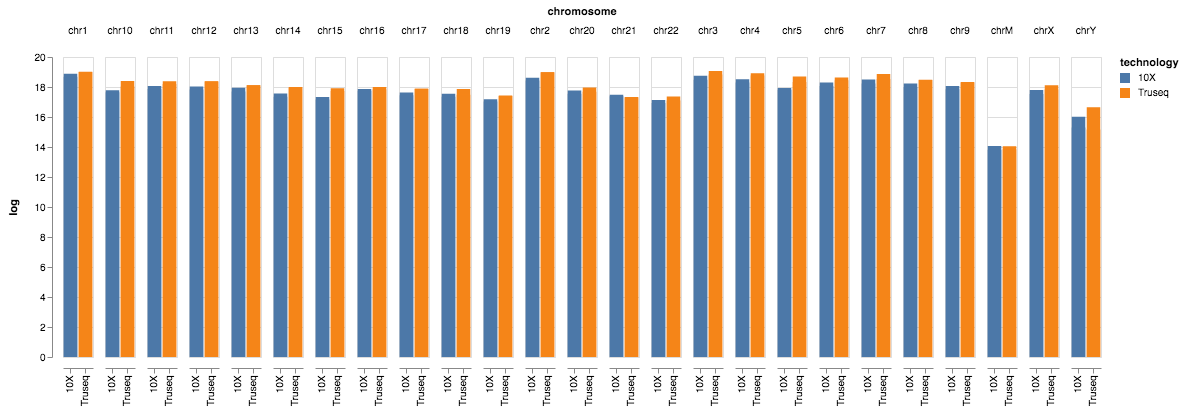

In [60]:
datasets_baseline = [colo829bl_10x_baseline, colo829t_10x_baseline, colo829bl_baseline, colo829t_baseline]
baseline_dataset = pd.concat(datasets_baseline, ignore_index=True)
baseline_dataset["log"] = baseline_dataset["mapped"].apply(np.log)


sample_chart = alt.Chart(baseline_dataset).mark_bar().encode(
        alt.X('sample:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('mapped:Q', axis=alt.Axis(title='Mapped reads')),
        color = alt.Color('sample:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)

tech_chart = alt.Chart(baseline_dataset).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('mapped:Q', axis=alt.Axis(title='Mapped reads')),
        color = alt.Color('technology:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)

logplot = alt.Chart(baseline_dataset).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'log:Q',
        color = alt.Color('technology:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)

#sample_chart | tech_chart | logplot
#sample_chart & tech_chart | logplot
#sample_chart
#logplot.properties(width=200, height=200)
logplot

## Absolute mapped reads for the telomeric curated coordinates

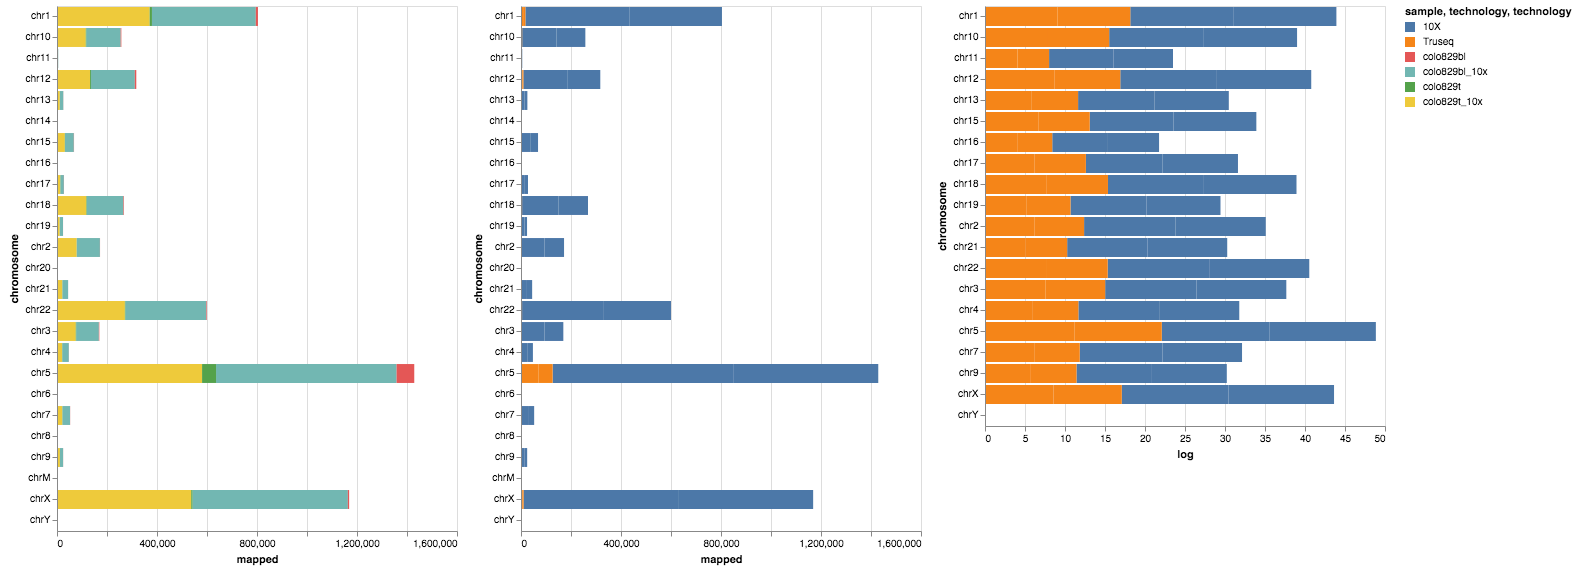

In [29]:
colo829bl_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-10X-sliced-idxstats-hg38.hist.csv")
colo829t_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-10X-sliced-idxstats-hg38.hist.csv")
colo829bl = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-sliced-idxstats-hg38.hist.csv")
colo829t = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-sliced-idxstats-hg38.hist.csv")

colo829bl_10x['technology'] = '10X'
colo829bl_10x['sample'] = 'colo829bl_10x'
colo829t_10x['technology'] = '10X'
colo829t_10x['sample'] = 'colo829t_10x'

colo829t['technology'] = 'Truseq'
colo829t['sample'] = 'colo829t'
colo829bl['technology'] = 'Truseq'
colo829bl['sample'] = 'colo829bl'

datasets = [colo829bl_10x, colo829t_10x, colo829bl, colo829t]

datasets = pd.concat(datasets, ignore_index=True)
datasets["log"] = datasets["mapped"].apply(np.log)


sample_chart = alt.Chart(datasets).mark_bar().encode(
        x = 'mapped:Q',
        y = 'chromosome:N',
        color = 'sample:N'
)

tech_chart = alt.Chart(datasets).mark_bar().encode(
        x = 'mapped:Q',
        y = 'chromosome:N',
        color = 'technology:N'
)

logplot = alt.Chart(datasets).mark_bar().encode(
        x = 'log:Q',
        y = 'chromosome:N',
        color = 'technology:N'
)


sample_chart | tech_chart | logplot